In [177]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

### Library

In [178]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import renom as rm
from renom.optimizer import Adam
from renom.cuda import set_cuda_active
# if you would like to use GPU, set True, otherwise you should be set to False
set_cuda_active(False)

In [179]:
def create_dataset(data, look_back, pred_length):
    exp, target = [], []
    for i in range(len(data) - look_back - pred_length):
        exp.append(data[i : i+look_back, :])
        target.append(data[i + look_back : i + look_back + pred_length, 9].T[0])
        
    n_features = np.array(exp).shape[2]
    exp = np.reshape(np.array(exp), [-1, look_back, n_features])
    target = np.reshape(np.array(target), [-1, 1])
    return exp, target

In [180]:
def split_data(X, y, test_size=0.1):
    pos = int(round(len(X) * (1-test_size)))
    X_train, y_train = X[:pos], y[:pos]
    X_test, y_test = X[pos:], y[pos:]
    return X_train, y_train, X_test, y_test, pos

In [181]:
with open('../intermediate_data/prep_data.pickle', mode='rb') as f:
    df = pickle.load(f)

In [182]:
df_std = df.copy()
stds, means = [], []
for col in df:
    std = df[col].std()
    mean = df[col].mean()
    df_std[col] = (df[col] - mean) / std
    stds.append(std)
    means.append(mean)
data = np.array(df_std)

In [183]:
look_back = 10
pred_length = 1
X, y = create_dataset(data, look_back, pred_length)

In [184]:
X_train, y_train, X_test, y_test, pos = split_data(X, y)

In [185]:
sequential = rm.Sequential([
    rm.Lstm(30),
    rm.Lstm(10),
    rm.Dense(1)
])

In [186]:
batch_size = 200
epoch = 500
N = len(X_train)
T = X_train.shape[1]

learning_curve = []
test_learning_curve = []
optimizer = Adam(lr=0.001)
for i in range(epoch):
    loss = 0
    test_loss = 0
    perm = np.random.permutation(N)
    for j in range(N//batch_size):
        train_batch = X_train[perm[j*batch_size : (j+1)*batch_size]]
        response_batch = y_train[perm[j*batch_size : (j+1)*batch_size]]
        l = 0
        with sequential.train():
            for t in range(T):
                z = sequential(train_batch[:, t, :])
                l = rm.mse(z, response_batch)
            sequential.truncate()
        l.grad().update(optimizer)
        loss += l.as_ndarray()
    loss = loss / (N // batch_size)
    l_test = 0
    for t in range(T):
        z = sequential(X_test[:, t, :])
        l_test = rm.mse(z, y_test)
    sequential.truncate()
    test_loss += l_test.as_ndarray()
    if i % 10 == 0:
        print("epoch:{:04d} loss:{:.5f} test_loss:{:.5f}".format(i, loss, test_loss))
    learning_curve.append(loss)
    test_learning_curve.append(test_loss)

epoch:0000 loss:0.50571 test_loss:0.46803
epoch:0010 loss:0.47943 test_loss:0.44877
epoch:0020 loss:0.46975 test_loss:0.45115
epoch:0030 loss:0.45252 test_loss:0.45642
epoch:0040 loss:0.44613 test_loss:0.45941
epoch:0050 loss:0.42158 test_loss:0.47380
epoch:0060 loss:0.40904 test_loss:0.47582
epoch:0070 loss:0.38459 test_loss:0.53078
epoch:0080 loss:0.37074 test_loss:0.55219
epoch:0090 loss:0.35437 test_loss:0.60066
epoch:0100 loss:0.33666 test_loss:0.64790
epoch:0110 loss:0.32080 test_loss:0.67843
epoch:0120 loss:0.31012 test_loss:0.72325
epoch:0130 loss:0.30466 test_loss:0.76003
epoch:0140 loss:0.28960 test_loss:0.76267
epoch:0150 loss:0.27881 test_loss:0.87173
epoch:0160 loss:0.26973 test_loss:0.85484
epoch:0170 loss:0.25343 test_loss:0.91904
epoch:0180 loss:0.24601 test_loss:0.96816
epoch:0190 loss:0.24235 test_loss:1.02436
epoch:0200 loss:0.23040 test_loss:1.02362
epoch:0210 loss:0.21981 test_loss:1.07920
epoch:0220 loss:0.21470 test_loss:1.13545
epoch:0230 loss:0.21405 test_loss:

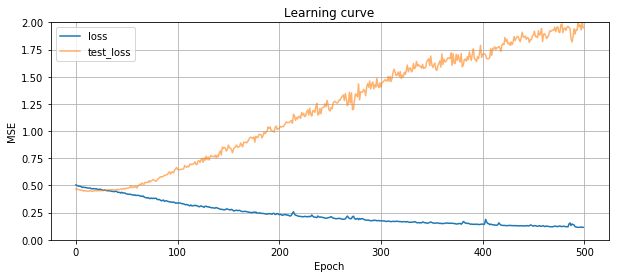

In [187]:
plt.figure(figsize=(10, 4))
plt.plot(learning_curve, label='loss')
plt.plot(test_learning_curve, label='test_loss', alpha=0.6)
plt.title('Learning curve')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.ylim(0, 2)
plt.legend()
plt.grid()

Root mean squared error:1.1094243789892


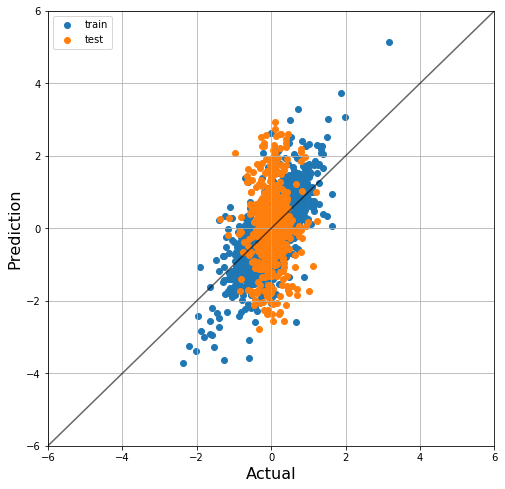

In [195]:
# predict test value
for t in range(T):
    y_test_pred = sequential(X_test[:, t, :])
sequential.truncate()
for t in range(T):
    y_train_pred = sequential(X_train[:, t, :])
sequential.truncate()

# # convert standardized heating-load to its original unit
y_train = y_train * stds[9] + means[9]
y_train_pred = y_train_pred * stds[9] + means[9]
y_test = y_test * stds[9] + means[9]
y_test_pred = y_test_pred * stds[9] + means[9]

# Root mean squared error
print("Root mean squared error:{}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))

plt.figure(figsize=(8, 8))
plt.plot([-6, 6], [-6, 6], c='k', alpha=0.6) # diagonal line
plt.scatter(y_train, y_train_pred, label = 'train')
plt.scatter(y_test, y_test_pred, label = 'test')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel('Actual', fontsize=16)
plt.ylabel('Prediction', fontsize=16)
plt.legend()
plt.grid()

In [189]:
train_price = []
tr_p = df['closeAsk'][0]
for v in y_train:
    tr_p += v[0]
    train_price.append(tr_p)
    
train_pred_price = []
tr_pr_p = df['closeAsk'][0]
for v in y_train_pred:
    tr_pr_p += v[0]
    train_pred_price.append(tr_pr_p)

test_price = []
te_p = df['closeAsk'][y_train.shape[0]]
for v in y_test:
    te_p += v[0]
    test_price.append(te_p)
    
test_pred_price = []
te_pr_p = df['closeAsk'][y_train.shape[0]]
for v in y_test_pred:
    te_pr_p += v[0]
    test_pred_price.append(te_pr_p)

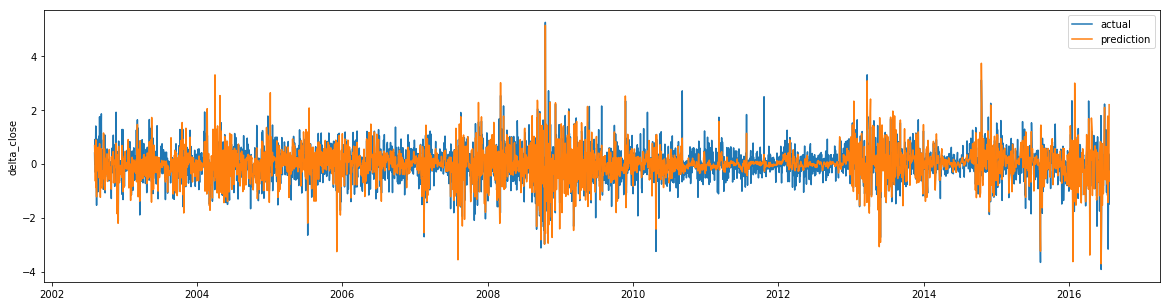

In [190]:
plt.figure(figsize = (20,5))
plt.plot(df_std[:pos].index, y_train, label = 'actual')
plt.plot(df_std[:pos].index, y_train_pred, label = 'prediction')
plt.ylabel('delta_close')
plt.legend()
plt.show()

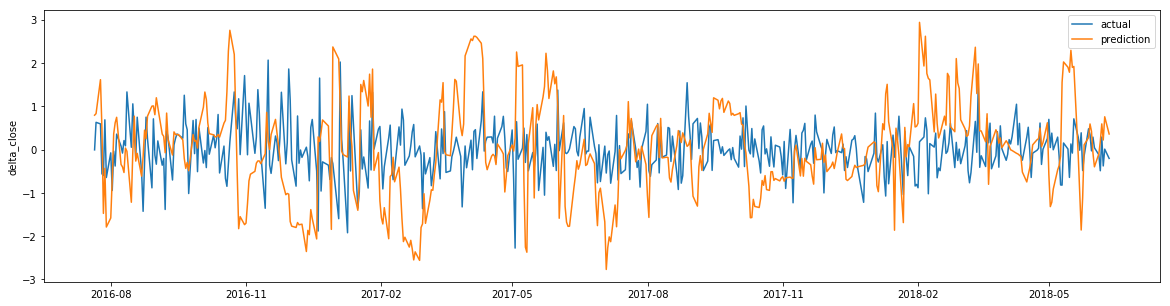

In [191]:
plt.figure(figsize = (20,5))
plt.plot(df_std[pos:-1 * (look_back + pred_length)].index, y_test, label = 'actual')
plt.plot(df_std[pos:-1 * (look_back + pred_length)].index, y_test_pred, label = 'prediction')
plt.ylabel('delta_close')
plt.legend()
plt.show()

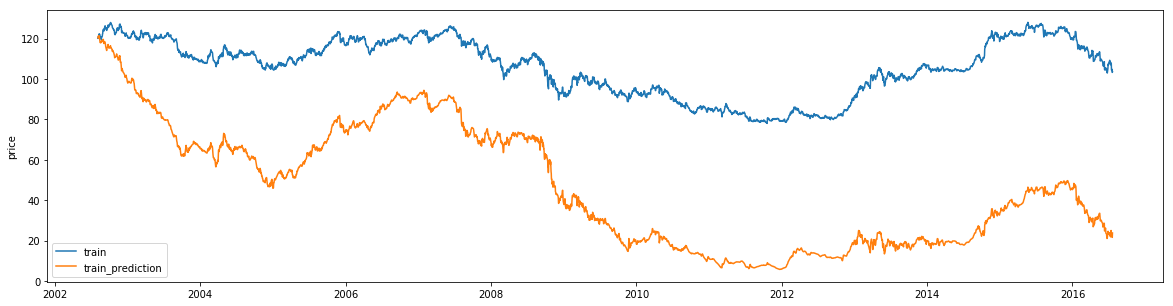

In [192]:
plt.figure(figsize = (20,5))
plt.plot(df_std[:pos].index, train_price, label = 'train')
plt.plot(df_std[:pos].index, train_pred_price, label = 'train_prediction')
plt.ylabel('price')
plt.legend()
plt.show()

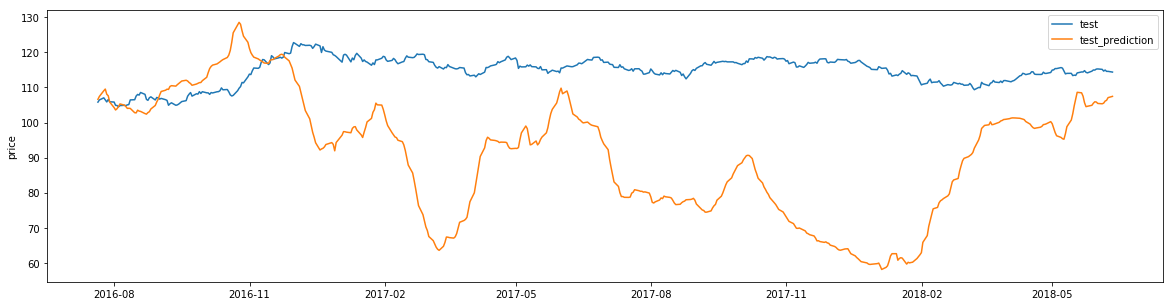

In [193]:
plt.figure(figsize = (20,5))
plt.plot(df_std[pos:-1 * (look_back + pred_length)].index, test_price, label = 'test')
plt.plot(df_std[pos:-1 * (look_back + pred_length)].index, test_pred_price, label = 'test_prediction')
plt.ylabel('price')
plt.legend()
plt.show()

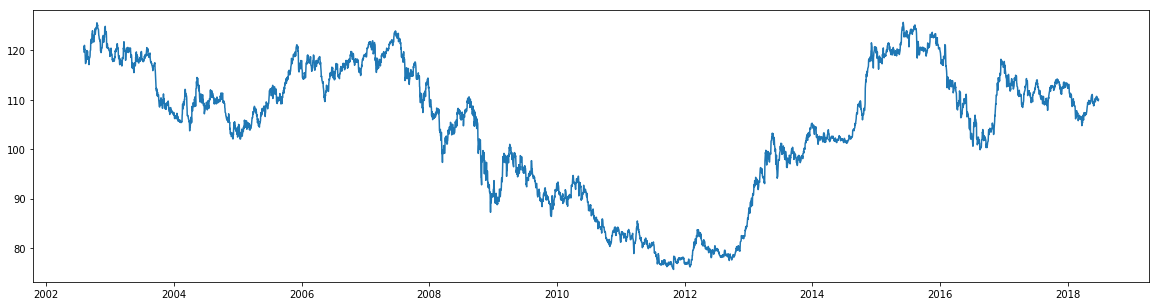

In [194]:
plt.figure(figsize = (20,5))
plt.plot(df['closeAsk'])
plt.show()